In [1]:
import pandas as pd, numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Load the 2016 data set into a pandas DataFrame
df2016 = pd.read_csv("/content/drive/MyDrive/CIND 820 Capstone Project/2016_Mississauga_Business_Directory.csv")

#NAICSTitle and NAICSDescr are in the wrong columns from 2016 to 2018.  2019 and 2021 are correct.
#Rename NAICSTitle to NAICSDescr ; NAICSSecto to NAICSTitle
df2016.rename(columns = {'NAICSDescr':'NAICSCat', 'NAICSTitle':'NAICSDescr'}, inplace = True)


# Create a column to hold the year
df2016['Year'] = 2016

# Load the 2017 data set into a pandas DataFrame
df2017 = pd.read_csv("/content/drive/MyDrive/CIND 820 Capstone Project/2017_Mississauga_Business_Directory.csv")

#NAICSTitle and NAICSDescr are in the wrong columns from 2016 to 2018.  2019 and 2021 are correct.
#Rename BID to BusinessID ; NAICSTitle to NAICSDescr ; NACISSecto to NAICSTitle ; 
df2017.rename(columns = {'BID':'BusinessID','NAICSTitle':'NAICSDescr','NAICSSecto':'NAICSCat'}, inplace = True)

# Create a column to hold the year
df2017['Year'] = 2017

#fix values on EmplRange that did not download properly in csv file from publisher site. Confirmed on json file from publisher.
df2017['EmplRange'] = df2017['EmplRange'].replace('1000 puls','1000+')

# Load the 2018 data set into a pandas DataFrame
df2018 = pd.read_csv("/content/drive/MyDrive/CIND 820 Capstone Project/2018_Mississauga_Business_Directory.csv")

#NAICSTitle and NAICSDescr are in the wrong columns from 2016 to 2018.  2019 and 2021 are correct.
#Rename ID1 to BusinessID ; NAICSTitle to NAICSDescr ; NAICSDescri to NAICSTitle
df2018.rename(columns = {'ID1':'BusinessID','NAICSTitle':'NAICSDescr','NACSDescri':'NAICSCat','Street_Add':'Address','Bldg_No':'BldgNo','Unit_No':'UnitNo','Modified_D':'EmplUpdate'}, inplace = True)

# Create a column to hold the year
df2018['Year'] = 2018
#correct the EmplRange category
df2018['EmplRange'] = df2018['EmplRange'].replace('1000 puls','1000+')

#eliminate the duplicate record for BusinessID 85606
df2018.drop(df2018[df2018['FID'] == 4602].index, inplace = True)

# Load the 2019 data set into a pandas DataFrame
df2019 = pd.read_csv("/content/drive/MyDrive/CIND 820 Capstone Project/2019_Mississauga_Business_Directory.csv")

#Rename ID to BusinessID ; NAICSTitle to NAICS_Title
df2019.rename(columns = {'ID':'BusinessID','NAICSTitle':'NAICSCat','Modified':'EmplUpdate'}, inplace = True)
#fix one bad NAICSCode based on what I know of the NAICS Code for this business in other years
df2019['NAICSCode'] = df2019['NAICSCode'].replace(-812910, 812910)


# Create a column to hold the year
df2019['Year'] = 2019
#correct the EmplRange category
df2019['EmplRange'] = df2019['EmplRange'].replace('1000 plus','1000+')

# Load the 2021 data set into a pandas DataFrame
df2021 = pd.read_csv("/content/drive/MyDrive/CIND 820 Capstone Project/2021_Mississauga_Business_Directory.csv")

#Rename ID to BusinessID ; NAICSTitle to NAICS_Title; X and Y to CENT_X and CENT_Y
df2021.rename(columns = {'ID':'BusinessID','NAICSTitle':'NAICSCat','X':'CENT_X','Y':'CENT_Y'}, inplace = True)

# Create a column to hold the year
df2021['Year'] = 2021
#correct the EmplRange category
df2021['EmplRange'] = df2021['EmplRange'].replace('1000 plus','1000+')
#correct records with no X Y value based on what I know about other records with same CENT_X CENT_Y value
df2021.loc[df2021.CENT_X == 608544.3664, 'X'] = -79.65277411
df2021.loc[df2021.CENT_Y == 4840490.34, 'Y'] = 43.70946585

# Merge the 2016, 2017 and 2018 data sets on the common identifier BusinessID
#merged_df = pd.merge(df2016, df2017, on='BusinessID')
#merged_traindf = pd.merge(merged_df, df2018, on='BusinessID')

#Concatenate 2016, 2017, 2018, 2019 and 2021 data sets
merged_df1 = pd.concat([df2016, df2017], axis=0)
merged_df2 = pd.concat([merged_df1, df2018], axis=0)
merged_df3 = pd.concat([merged_df2, df2019], axis=0)
merged_complete_df = pd.concat([merged_df3, df2021], axis=0)

# Add a new unique identifier "RecordID" to the merged data set starting at 1
#merged_complete_df['RecordID'] = merged_complete_df.map(hash)
#merged_complete_df['RecordID'] = pd.factorize(all_data['_ID'])[0]
merged_complete_df = merged_complete_df.reset_index()
merged_complete_df = merged_complete_df.rename(columns={"index":"RecordID"})
merged_complete_df['RecordID'] = merged_complete_df.index + 1

#fix two bad NAICSCat based on what I know of THE NAICS Category and NAICS Code for these two business in other years
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Accommodatio','Accommodation')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('ransportation','Transportation')
merged_complete_df['NAICSDescr'] = merged_complete_df['NAICSDescr'].replace('813310 - Social Advocacy Organizations','Social Advocacy Organizations')
#fix a record with an incorrect ward based on what I know about the same record in other years
merged_complete_df['Ward'] = merged_complete_df['Ward'].replace(105,10)
#fix a record with an incorrect postal code based on the postal code the business has in other years
merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].replace("v","L5G 4P3")
merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].replace("L5 J1J4","L5J 1J4")
merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].replace(" L5T 1N8","L5T 1N8")

#Is the business new to the directory in a given year?  Create a column 'isnew' and populate with true or false.
s1 = merged_complete_df.groupby('Year')['BusinessID'].value_counts()
s2 = s1.unstack().diff().replace({0: 'No', np.nan: 'Yes'}).stack()
merged_complete_df['isnew'] = merged_complete_df.set_index(['Year', 'BusinessID']).index.map(s2)

#Mark the last year a business existed in the directory by populating a column to hold the Closed status
merged_complete_df['Closed'] = 'No'
not_last_rows = merged_complete_df['BusinessID'].duplicated(keep='last')
merged_complete_df.loc[~not_last_rows, 'Closed'] = 'Yes'

#Remove the closed status = yes from the 2021 records as we do not have 2022 data to tell us which closed
merged_complete_df.loc[merged_complete_df['Year'] == 2021, 'Closed'] = 'No'
#Remove the isnew status = yes from the 2016 records as we do not have 2015 data to tell us which were new in 2016
merged_complete_df.loc[merged_complete_df['Year'] == 2016, 'isnew'] = 'No'

#Missing values in the EmplRange field account for 2646 of 78032 records or 3.39%
#Used backwards and then forwards fill na values in emplrange field as these are actual values for companies
merged_complete_df['EmplRange'] = merged_complete_df.groupby('BusinessID')['EmplRange'].ffill().bfill()

#Missing values in the NAICSCode NAICSCat field account for 145 of 78032 records or 0.185%
#change NAICSCode 1 to no value
merged_complete_df['NAICSCode'] = merged_complete_df['NAICSCode'].replace(1, np.NAN)
merged_complete_df['NAICSCode'] = merged_complete_df['NAICSCode'].replace(r'^\s*$', np.nan, regex=True)

#Used backwards and then forwards fill na values in NAICS fields as these are actual values for companies
merged_complete_df['NAICSCode'] = merged_complete_df.groupby('BusinessID')['NAICSCode'].ffill().bfill()

merged_complete_df['NAICSDescr'] = merged_complete_df['NAICSDescr'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['NAICSDescr'] = merged_complete_df.groupby('BusinessID')['NAICSDescr'].ffill().bfill()

merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['NAICSCat'] = merged_complete_df.groupby('BusinessID')['NAICSCat'].ffill().bfill()

#Used backwards and then forwards fill na values in X,Y,CENT_X,CENT_Y,POSTALCODE, Location
merged_complete_df['X'] = merged_complete_df['X'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['X'] = merged_complete_df.groupby('BusinessID')['X'].ffill().bfill()
merged_complete_df['X'] = merged_complete_df['X'].replace(np.nan, 0)

merged_complete_df['Y'] = merged_complete_df['Y'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['Y'] = merged_complete_df.groupby('BusinessID')['Y'].ffill().bfill()
merged_complete_df['Y'] = merged_complete_df['Y'].replace(np.nan, 0)

merged_complete_df['CENT_X'] = merged_complete_df['CENT_X'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['CENT_X'] = merged_complete_df.groupby('BusinessID')['CENT_X'].ffill().bfill()

merged_complete_df['CENT_Y'] = merged_complete_df['CENT_Y'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['CENT_Y'] = merged_complete_df.groupby('BusinessID')['CENT_Y'].ffill().bfill()

merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['PostalCode'] = merged_complete_df.groupby('BusinessID')['PostalCode'].ffill().bfill()

#limit postal code to first 3 characters to allow for categorization that is less granular
#merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].str.slice(0,3)
merged_complete_df['PostalCode'] = merged_complete_df['PostalCode'].str[:3]

merged_complete_df['Location'] = merged_complete_df['Location'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['Location'] = merged_complete_df.groupby('BusinessID')['Location'].ffill().bfill()
#replace remainging 5 records with the most tagged value
merged_complete_df['Location'] = merged_complete_df['Location'].replace(np.nan, 'Northeast EA (East)')

#fill the following fields TollFree, BldgNo, UnitNo, WebAddress, Email, Fax, Phone with binary values
merged_complete_df['TollFree'] = merged_complete_df['TollFree'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['TollFree'] = merged_complete_df['TollFree'].replace(np.nan, 'No')
merged_complete_df['TollFree'] = np.where(merged_complete_df['TollFree'] != 'No', 'Yes', merged_complete_df['TollFree'])

merged_complete_df['EMail'] = merged_complete_df['EMail'].replace(r'\S*@\S*\s?', np.nan, regex=True)
merged_complete_df['EMail'] = merged_complete_df['EMail'].replace(np.nan, 'Yes')
merged_complete_df['EMail'] = np.where(merged_complete_df['EMail'] != 'Yes', 'No', merged_complete_df['EMail'])

merged_complete_df['Fax'] = merged_complete_df['Fax'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['Fax'] = merged_complete_df['Fax'].replace(np.nan, 'No')
merged_complete_df['Fax'] = np.where(merged_complete_df['Fax'] != 'No', 'Yes', merged_complete_df['TollFree'])

merged_complete_df['Phone'] = merged_complete_df['Phone'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['Phone'] = merged_complete_df['Phone'].replace(np.nan, 'No')
merged_complete_df['Phone'] = np.where(merged_complete_df['Phone'] != 'No', 'Yes', merged_complete_df['TollFree'])

merged_complete_df['BldgNo'] = merged_complete_df['BldgNo'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['BldgNo'] = merged_complete_df['BldgNo'].replace(np.nan, 'No')
merged_complete_df['BldgNo'] = np.where(merged_complete_df['BldgNo'] != 'No', 'Yes', merged_complete_df['BldgNo'])

merged_complete_df['UnitNo'] = merged_complete_df['UnitNo'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['UnitNo'] = merged_complete_df['UnitNo'].replace(np.nan, 'No')
merged_complete_df['UnitNo'] = np.where(merged_complete_df['UnitNo'] != 'No', 'Yes', merged_complete_df['UnitNo'])


merged_complete_df['WebAddress'] = merged_complete_df['WebAddress'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['WebAddress'] = merged_complete_df['WebAddress'].replace(np.nan, 'No')
merged_complete_df['WebAddress'] = np.where(merged_complete_df['WebAddress'] != 'No', 'Yes', merged_complete_df['WebAddress'])

#limit NAICS to first 2 numbers to allow for categorization that is less granular. Need to change to int so sort works
#then select the first 2 numbers and retirn to str
#merged_complete_df['NAICSCode'] = merged_complete_df['NAICSCode'].str.slice(0,2)
merged_complete_df['NAICSCode'] = merged_complete_df['NAICSCode'].astype(int)
merged_complete_df.NAICSCode.astype(int)
merged_complete_df['NAICSCode'] = merged_complete_df.NAICSCode.astype(str).str[:2].astype(int)
merged_complete_df['NAICSCode'] = merged_complete_df['NAICSCode'].astype(str)

#convert EmplRange to ordinal
empl_range_mapper = {'1 to 4': 1, '5 to 9': 2, '10 to 19': 3,'20 to 49': 4, '50 to 99': 5, '100 to 299': 6, '300 to 499': 7, '500 to 999': 8, '1000+': 9 }
merged_complete_df['EmplRange'].replace(empl_range_mapper, inplace=True)

#data['EmplRange'] = data['EmplRange'].fillna(data['EmplRange'].mean(), inplace=True)
merged_complete_df['EmplRange'] = merged_complete_df['EmplRange'].replace(r'^\s*$', np.nan, regex=True)
merged_complete_df['EmplRange'] = merged_complete_df['EmplRange'].replace(np.NAN,1)
merged_complete_df['EmplRange'] = merged_complete_df['EmplRange'].astype(int)
merged_complete_df.EmplRange.astype(int)

#fix inconsistences in NAICSCat for 2017 records and standardize NAICSCat to match Statistics Canada categories so we can compare easily to their study results
#example - has both Accommodation and Accommodation and Food Services as the NAICSCat for the same NAICSCode
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Accommodation','Accommodation and Food Services')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Administrative','Administrative and Support, Waste Management and Remediation Services')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Administrative and Support, Waste Management and R','Administrative and Support, Waste Management and Remediation Services')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Arts','Arts, Entertainment and Recreation')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Educational','Educational Services')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Finance','Finance and Insurance')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Health Care','Health Care and Social Assistance')
#found one record where NAICSCode is incorrect for NAICSCat. This business BusinessID89649 'IT Wizer Solutions' described itself in a different category every year! 
merged_complete_df['NAICSCode'] = np.where((merged_complete_df['NAICSCode'] == '54') & (merged_complete_df['NAICSCat'] == 'Information'), '51', merged_complete_df['NAICSCode'])
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Information','Information and Cultural Industries')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Management','Management of Companies and Enterprises')
#found one record where NAICSCode is incorrect for NAICSCat. This business is BusinessID13405 'World 17 / ProGroup' 
merged_complete_df['NAICSCode'] = np.where((merged_complete_df['NAICSCode'] == '52') & (merged_complete_df['NAICSCat'] == 'Professional, Scientific and Technical Services'), '54', merged_complete_df['NAICSCode'])
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Professional','Professional, Scientific and Technical Services')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Real Estate','Real Estate and Rental and Leasing')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Retail','Retail Trade') # maps to 44 and 45 in NAICSCode. Only one that does.
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Transportation','Transportation and Warehousing')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Transportation And Warehousing','Transportation and Warehousing')
merged_complete_df['NAICSCat'] = merged_complete_df['NAICSCat'].replace('Wholesale','Wholesale Trade')

#found one record where StreetNo is incorrect and has part of the phone number instead. This business is BusinessID17933 'Jade Xpress' 
merged_complete_df['StreetNo'] = np.where((merged_complete_df['StreetNo'] == '905629') & (merged_complete_df['BusinessID'] == '17933'), '1575', merged_complete_df['StreetNo'])

#drop these columns where the data is too sparse to fill reliably
merged_complete_df.drop(['EmplUpdate','Character','CHArea','Modified','BIA_NAME','BIAFulName','Sector_Des','PIN'], axis=1, inplace=True)

# Save the merged data set to a new file
merged_complete_df.to_csv("/content/drive/MyDrive/CIND 820 Capstone Project/merged_completedata.csv", index=False)

#Create closed company data frame
closed_df = merged_complete_df
#Add a year closed column and bump up one year past last year in directory
closed_df = closed_df[closed_df['Closed'] == 'Yes'] 
closed_df['YearClosed'] = closed_df.groupby('BusinessID').Year.transform(np.roll, shift=-1)
#create an opened company data frame
opened_df = merged_complete_df
opened_df = opened_df[opened_df['isnew'] == 'Yes'] 

# Save the closed and opened data sets to new files
closed_df.to_csv("/content/drive/MyDrive/CIND 820 Capstone Project/closed_data.csv", index=False)
opened_df.to_csv("/content/drive/MyDrive/CIND 820 Capstone Project/opened_data.csv", index=False)

# Merge the 2019 and 2021 data sets on the common identifier BusinessID
merged_traintestdf = pd.merge(df2019, df2021, on='BusinessID')


In [2]:
merged_complete_df.head()

,RecordID,X,Y,FID,BusinessID,Name,Address,StreetNo,StreetName,BldgNo,UnitNo,PostalCode,Location,Ward,NAICSCode,NAICSCat,NAICSDescr,Phone,Fax,TollFree,EMail,WebAddress,EmplRange,CENT_X,CENT_Y,Year,isnew,Closed
0,1,-79.689829,43.644181,1,1055,Golf Trends Inc.,300 Ambassador Dr,300,Ambassador Dr,No,No,L5T,Gateway EA (East),5,41,Wholesale Trade,Amusement and Sporting Goods Wholesaler-Distri...,Yes,Yes,Yes,Yes,Yes,3,605668.2538,4.833187e+06,2016,No,No
1,2,-79.689419,43.644988,2,1057,Apex Graphics Inc.,320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Support Activities for Printing,Yes,Yes,No,Yes,Yes,4,605699.9370,4.833277e+06,2016,No,No
2,3,-79.689419,43.644988,3,1058,"Sands, John & Associates Limited",320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Support Activities for Printing,Yes,Yes,No,No,No,5,605699.9370,4.833277e+06,2016,No,No
3,4,-79.689419,43.644988,4,1060,Printmedia-Tackaberry Times,320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Other Printing,Yes,Yes,No,Yes,Yes,1,605699.9370,4.833277e+06,2016,No,No
4,5,-79.690664,43.645493,5,1061,S W R Industries Ltd.,321 Ambassador Dr,321,Ambassador Dr,No,No,L5T,Gateway EA (East),5,41,Wholesale Trade,"Industrial Machinery, Equipment and Supplies W...",Yes,Yes,No,Yes,Yes,2,605598.6442,4.833332e+06,2016,No,No


In [ ]:
# Save the merged data set to a new file
#merged_traintestdf.to_csv("/content/drive/MyDrive/CIND 820 Capstone Project/merged_traintestdata.csv", index=False)

In [3]:
#use to check for null values and make decisions about columns to drop
#merged_complete_df['Location'].isnull().values.any()
#merged_complete_df['Location'].isnull().sum()
#merged_complete_df['Location'].head()

merged_complete_df.isnull().sum()



RecordID      0
X             0
Y             0
FID           0
BusinessID    0
Name          0
Address       0
StreetNo      0
StreetName    0
BldgNo        0
UnitNo        0
PostalCode    0
Location      0
Ward          0
NAICSCode     0
NAICSCat      0
NAICSDescr    0
Phone         0
Fax           0
TollFree      0
EMail         0
WebAddress    0
EmplRange     0
CENT_X        0
CENT_Y        0
Year          0
isnew         0
Closed        0
dtype: int64

In [4]:
merged_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78032 entries, 0 to 78031
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RecordID    78032 non-null  int64  
 1   X           78032 non-null  float64
 2   Y           78032 non-null  float64
 3   FID         78032 non-null  int64  
 4   BusinessID  78032 non-null  int64  
 5   Name        78032 non-null  object 
 6   Address     78032 non-null  object 
 7   StreetNo    78032 non-null  object 
 8   StreetName  78032 non-null  object 
 9   BldgNo      78032 non-null  object 
 10  UnitNo      78032 non-null  object 
 11  PostalCode  78032 non-null  object 
 12  Location    78032 non-null  object 
 13  Ward        78032 non-null  int64  
 14  NAICSCode   78032 non-null  object 
 15  NAICSCat    78032 non-null  object 
 16  NAICSDescr  78032 non-null  object 
 17  Phone       78032 non-null  object 
 18  Fax         78032 non-null  object 
 19  TollFree    78032 non-nul

In [5]:
merged_complete_df.head()

,RecordID,X,Y,FID,BusinessID,Name,Address,StreetNo,StreetName,BldgNo,UnitNo,PostalCode,Location,Ward,NAICSCode,NAICSCat,NAICSDescr,Phone,Fax,TollFree,EMail,WebAddress,EmplRange,CENT_X,CENT_Y,Year,isnew,Closed
0,1,-79.689829,43.644181,1,1055,Golf Trends Inc.,300 Ambassador Dr,300,Ambassador Dr,No,No,L5T,Gateway EA (East),5,41,Wholesale Trade,Amusement and Sporting Goods Wholesaler-Distri...,Yes,Yes,Yes,Yes,Yes,3,605668.2538,4.833187e+06,2016,No,No
1,2,-79.689419,43.644988,2,1057,Apex Graphics Inc.,320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Support Activities for Printing,Yes,Yes,No,Yes,Yes,4,605699.9370,4.833277e+06,2016,No,No
2,3,-79.689419,43.644988,3,1058,"Sands, John & Associates Limited",320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Support Activities for Printing,Yes,Yes,No,No,No,5,605699.9370,4.833277e+06,2016,No,No
3,4,-79.689419,43.644988,4,1060,Printmedia-Tackaberry Times,320 Ambassador Dr,320,Ambassador Dr,No,No,L5T,Gateway EA (East),5,32,Manufacturing,Other Printing,Yes,Yes,No,Yes,Yes,1,605699.9370,4.833277e+06,2016,No,No
4,5,-79.690664,43.645493,5,1061,S W R Industries Ltd.,321 Ambassador Dr,321,Ambassador Dr,No,No,L5T,Gateway EA (East),5,41,Wholesale Trade,"Industrial Machinery, Equipment and Supplies W...",Yes,Yes,No,Yes,Yes,2,605598.6442,4.833332e+06,2016,No,No


array([[<AxesSubplot:title={'center':'RecordID'}>,
        <AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>],
       [<AxesSubplot:title={'center':'FID'}>,
        <AxesSubplot:title={'center':'BusinessID'}>,
        <AxesSubplot:title={'center':'Ward'}>],
       [<AxesSubplot:title={'center':'EmplRange'}>,
        <AxesSubplot:title={'center':'CENT_X'}>,
        <AxesSubplot:title={'center':'CENT_Y'}>],
       [<AxesSubplot:title={'center':'Year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

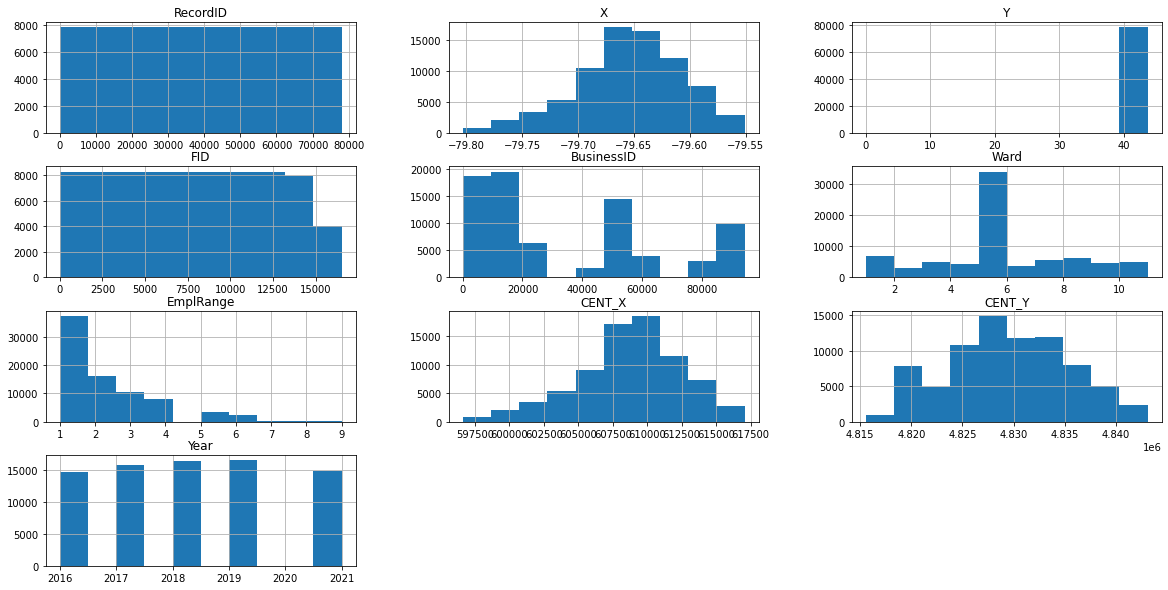

In [6]:
#histograms of numeric attributes
merged_complete_df.hist(figsize=(20, 10))

<AxesSubplot:>

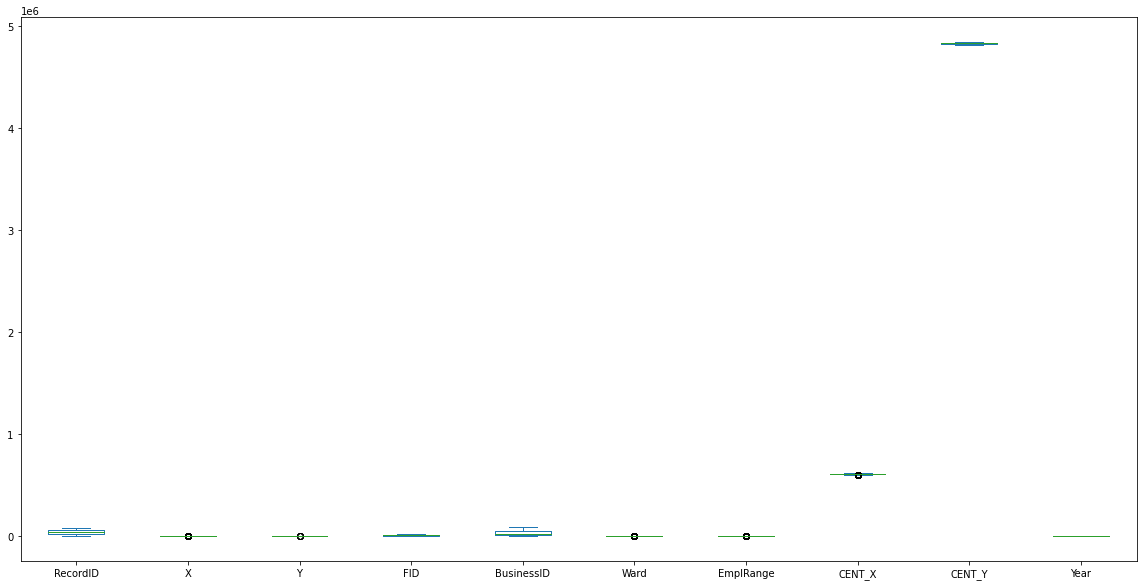

In [7]:
#boxplots of numeric attributes
merged_complete_df.plot.box(figsize=(20, 10))

<AxesSubplot:xlabel='EmplRange'>

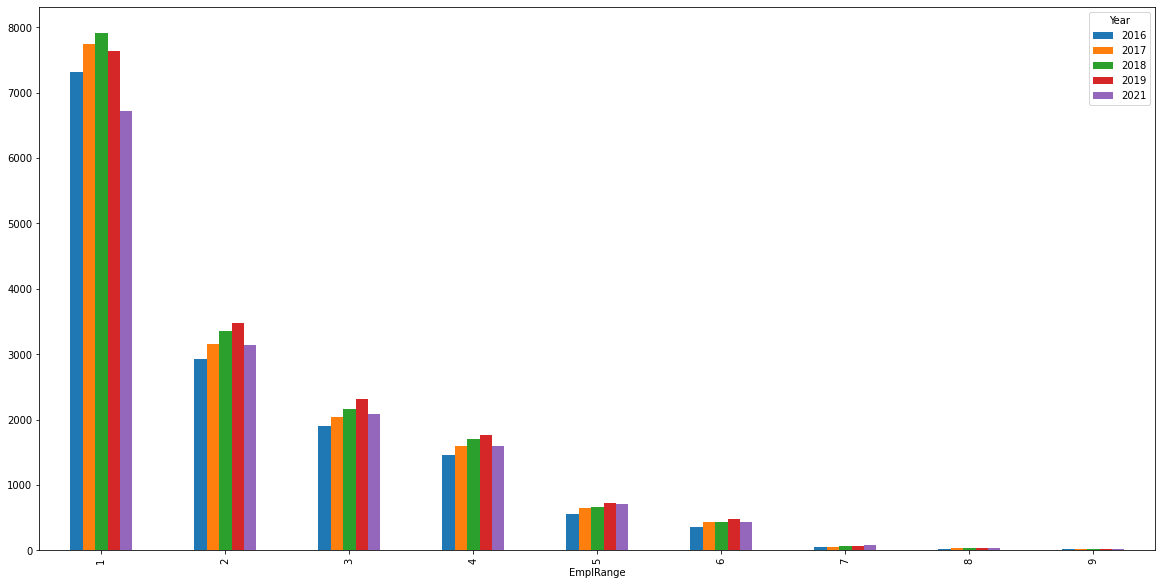

In [8]:
#bar plots of categorical attributes by year - EmplRange
(merged_complete_df.groupby(['Year','EmplRange'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))

<AxesSubplot:xlabel='NAICSCat'>

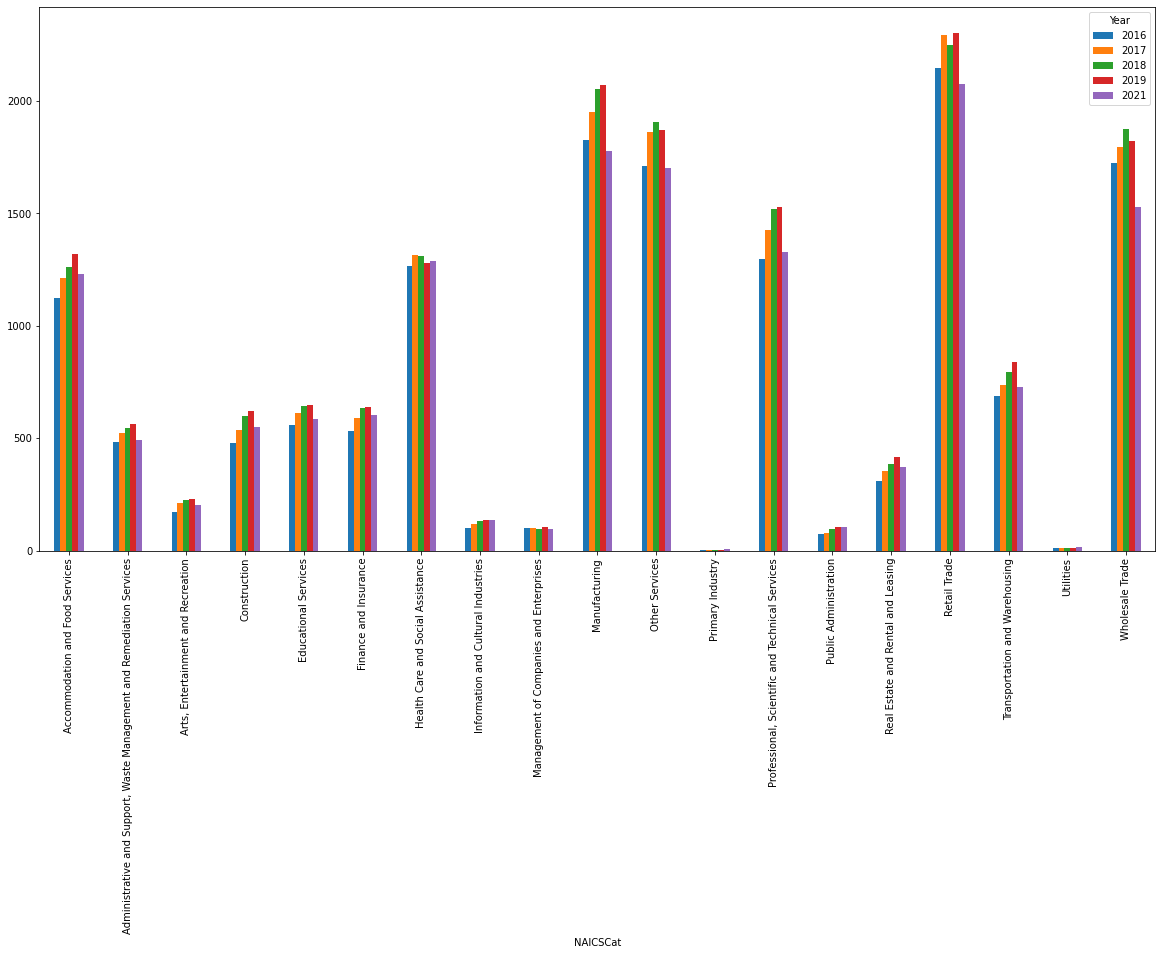

In [9]:
#bar plots of categorical attributes by year - NAICSCat
(merged_complete_df.groupby(['Year','NAICSCat'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))

<AxesSubplot:xlabel='NAICSCode'>

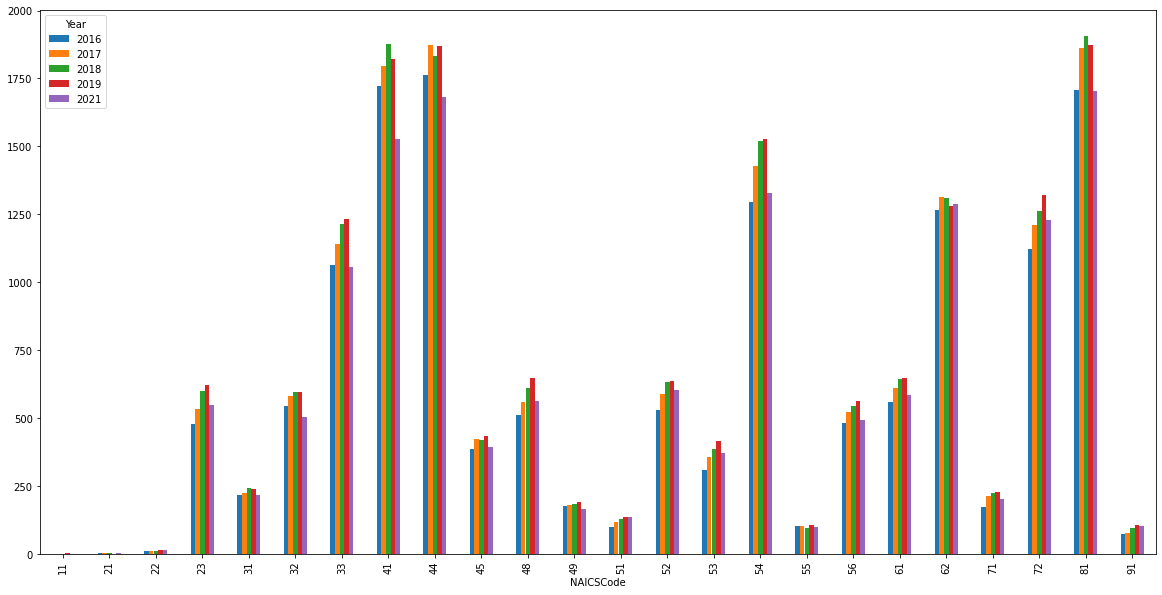

In [10]:
#bar plots of categorical attributes by year - NAICSCode
(merged_complete_df.groupby(['Year','NAICSCode'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))

<AxesSubplot:xlabel='Closed'>

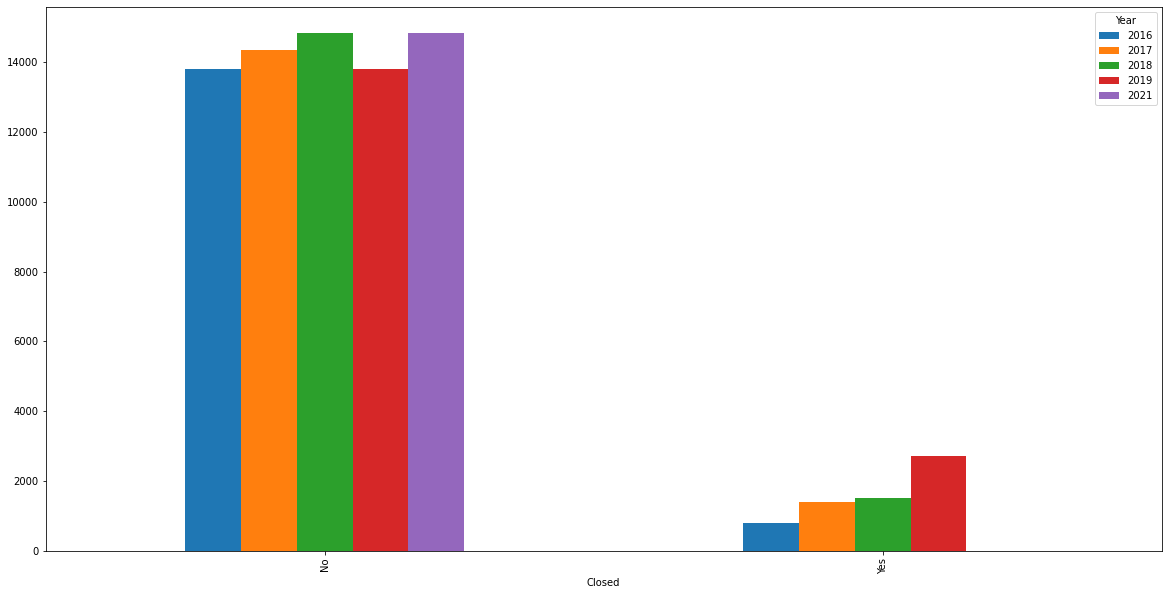

In [11]:
#bar plots of categorical attributes by year - Closed
(merged_complete_df.groupby(['Year','Closed'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))

<AxesSubplot:xlabel='isnew'>

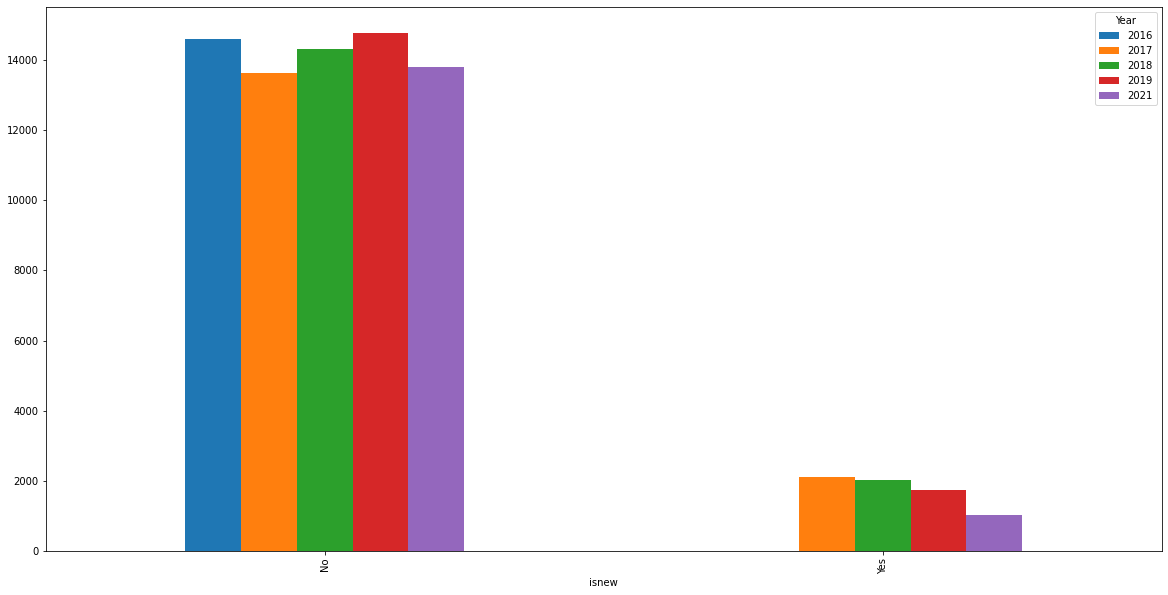

In [12]:
#bar plots of categorical attributes by year - isnew
(merged_complete_df.groupby(['Year','isnew'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))

<AxesSubplot:xlabel='Location'>

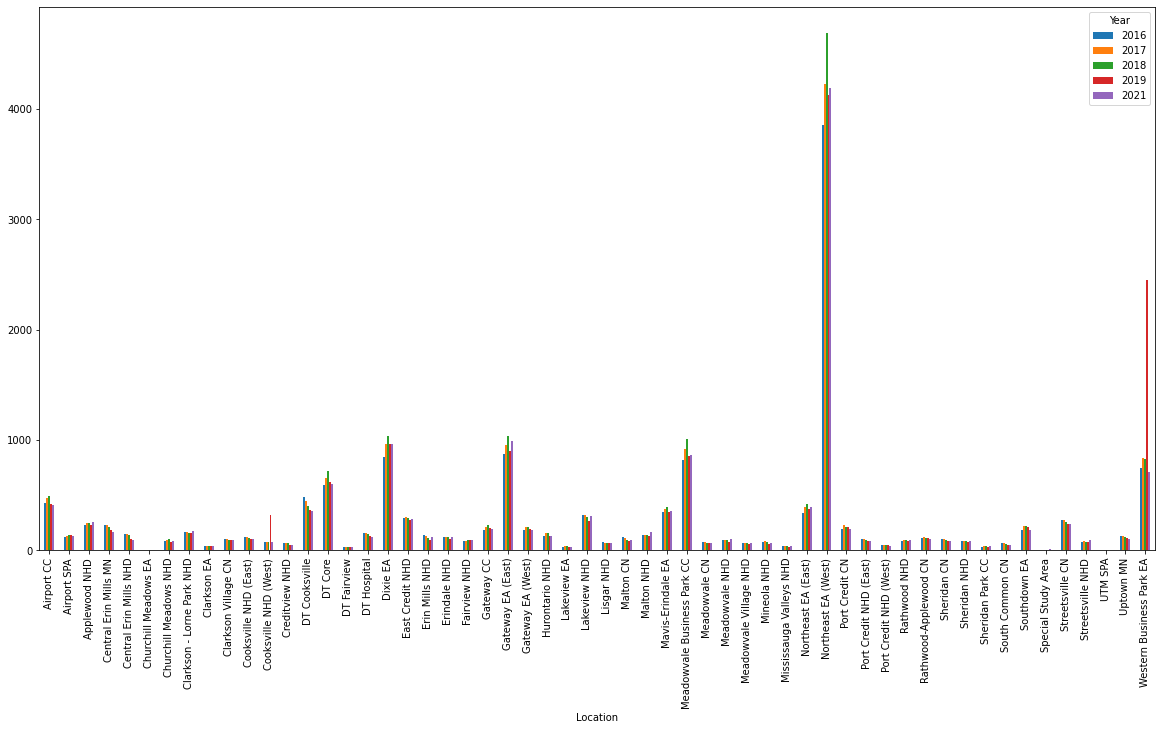

In [13]:
#bar plots of categorical attributes by year - Location
(merged_complete_df.groupby(['Year','Location'])['Year']
    .count().unstack('Year').plot.bar(figsize=(20, 10)))